In [2]:
from validphys.api import API
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from validphys.fkparser import load_fktable
from collections import defaultdict
from typing import List, Dict
from collections import namedtuple

from n3fit.layers import DIS

from gen_dicts import generate_dicts
from utils import XGRID, extract_independent_columns
from model_utils import *

Using Keras backend


In [3]:
seed = 14132124
DEBUG = False

In [4]:
# List of DIS dataset
dataset_inputs = [
  #{'dataset': 'NMC_NC_NOTFIXED_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'NMC_NC_NOTFIXED_P_EM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'SLAC_NC_NOTFIXED_P_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'SLAC_NC_NOTFIXED_D_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'BCDMS_NC_NOTFIXED_P_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'BCDMS_NC_NOTFIXED_D_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'CHORUS_CC_NOTFIXED_PB_DW_NU-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'CHORUS_CC_NOTFIXED_PB_DW_NB-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'NUTEV_CC_NOTFIXED_FE_DW_NU-SIGMARED', 'cfac': ['MAS'], 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'NUTEV_CC_NOTFIXED_FE_DW_NB-SIGMARED', 'cfac': ['MAS'], 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'HERA_NC_318GEV_EM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'HERA_NC_225GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'HERA_NC_251GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'HERA_NC_300GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'HERA_NC_318GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'HERA_CC_318GEV_EM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'HERA_CC_318GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'HERA_NC_318GEV_EAVG_CHARM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'HERA_NC_318GEV_EAVG_BOTTOM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
]

# Dictionary for validphys API
common_dict = dict(
    dataset_inputs=dataset_inputs,
    metadata_group="nnpdf31_process",
    use_cuts='internal',
    datacuts={'q2min': 3.49, 'w2min': 12.5},
    theoryid=40000000,
    t0pdfset='NNPDF40_nnlo_as_01180',
    use_t0=True
)

In [5]:
# Retrieve data from NNPDF
groups_data = API.procs_data(**common_dict)
tuple_of_dicts = generate_dicts(groups_data)
fk_table_dict = tuple_of_dicts.fk_tables
central_data_dict = tuple_of_dicts.central_data

In [6]:
C_sys = API.dataset_inputs_t0_covmat_from_systematics(**common_dict)
C = API.groups_covmat_no_table(**common_dict)

# Serialize covmat
C.to_pickle(path='./serialised_data/covmat.pkl')
C_index = C.index
C_col = C.columns
#C = pd.DataFrame(C_sys, index=C_index, columns=C_col)
#C = pd.DataFrame(np.identity(C.shape[0]), index=C_index, columns=C_col)
Cinv = np.linalg.inv(C)
Cinv = pd.DataFrame(Cinv, index=C_index, columns=C_col)


L = np.linalg.cholesky(Cinv)
L = L.T
Linv = np.linalg.inv(L)

LHAPDF 6.5.4 loading /opt/homebrew/Caskroom/miniconda/base/envs/nnpdf/share/LHAPDF/NNPDF40_nnlo_as_01180/NNPDF40_nnlo_as_01180_0000.dat
NNPDF40_nnlo_as_01180 PDF set, member #0, version 1; LHAPDF ID = 331100


In [7]:
# Construct the big FK table matrix
ndata = 0
dataname_from_covmat = Cinv.index.get_level_values('dataset').unique()

vecs_for_stack = []
for i, (exp, fk) in enumerate(fk_table_dict.items()):
  ndata += fk.shape[0]
  if exp == dataname_from_covmat[i]:
    vecs_for_stack.append(fk.numpy().reshape((fk.shape[0], fk.shape[1] * fk.shape[2])))
  else:
    raise ValueError(f'Problem encountered {exp} != {dataname_from_covmat[i]}')

FK = np.vstack([fk.numpy().reshape((fk.shape[0], fk.shape[1] * fk.shape[2])) for fk in fk_table_dict.values()])
#FK = np.vstack(vecs_for_stack)

try:
  assert(FK.shape[0] == ndata)
except AssertionError:
  print('The number of points does not match.')

# Check that this FK is what we expect
try:
  test_matrix = np.random.rand(FK.shape[0], FK.shape[0])
  # Matrix product
  mat_prod = FK.T @ test_matrix

  # Tensor product
  shape = (*fk.shape[1:], *fk.shape[1:])
  result = np.zeros((fk.shape[1], fk.shape[2], FK.shape[0]))
  I = 0
  for fk in fk_table_dict.values():
    ndata = fk.shape[0]
    result += np.einsum('Iia, IJ -> iaJ',fk, test_matrix[I : I + ndata, :])
    I += ndata
  
  result_flatten = result.reshape((result.shape[0] * result.shape[1], result.shape[2]))
  assert(np.allclose(result_flatten, mat_prod))
  assert(np.allclose(result, mat_prod.reshape((result.shape[0], result.shape[1], result.shape[2]))))
except AssertionError:
  print('A problem occurred')

# Perform singular value decomposition
fk_l, fk_evals, fk_r = np.linalg.svd(FK)
for idx, val in enumerate(fk_evals):
  print(f'{idx} : {val}')

0 : 8.782119750976562
1 : 8.04540729522705
2 : 7.4657158851623535
3 : 6.60493278503418
4 : 6.310225486755371
5 : 6.007370471954346
6 : 5.936917781829834
7 : 5.688965797424316
8 : 5.602202892303467
9 : 5.378738880157471
10 : 5.268031597137451
11 : 4.970888614654541
12 : 4.62387228012085
13 : 4.44365930557251
14 : 4.424646377563477
15 : 4.324334144592285
16 : 4.149662494659424
17 : 4.100085258483887
18 : 4.071784019470215
19 : 3.7806379795074463
20 : 3.7313945293426514
21 : 3.4071896076202393
22 : 3.390204668045044
23 : 3.361095905303955
24 : 3.3433947563171387
25 : 3.3103833198547363
26 : 3.1575381755828857
27 : 2.827335834503174
28 : 2.803805351257324
29 : 2.7542762756347656
30 : 2.4166758060455322
31 : 2.2828168869018555
32 : 2.1672592163085938
33 : 2.011521339416504
34 : 1.8212560415267944
35 : 1.7508244514465332
36 : 1.6801139116287231
37 : 1.6188418865203857
38 : 1.5899145603179932
39 : 1.524815559387207
40 : 1.4785726070404053
41 : 1.386460304260254
42 : 1.2814574241638184
43 : 1.

In [8]:
import jax.numpy as jnp

from jax import random
from jax.example_libraries import optimizers
from jax import jit, grad, vmap

import functools

import neural_tangents as nt
from neural_tangents import stax

In [9]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib
import seaborn as sns

sns.set(font_scale=1.3)
sns.set_style("darkgrid", {"axes.facecolor": ".95"})

import matplotlib.pyplot as plt

def format_plot(x=None, y=None):
  # plt.grid(False)
  ax = plt.gca()
  if x is not None:
    plt.xlabel(x, fontsize=20)
  if y is not None:
    plt.ylabel(y, fontsize=20)

def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1],
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

legend = functools.partial(plt.legend, fontsize=10)

/var/folders/l5/l1kl3n_11gx3zm7b0wxctqym0000gn/T/ipykernel_89047/959879427.py:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


In [10]:
def plot_fn(train, test, *fs):
  train_xs, train_ys = train

  plt.plot(train_xs, train_ys, 'ro', markersize=10, label='train')

  if test != None:
    test_xs, test_ys = test
    plt.plot(test_xs, test_ys, 'k--', linewidth=3, label='$f(x)$')

    for f in fs:
      plt.plot(test_xs, f(test_xs), '-', linewidth=3)

  plt.xlim([-jnp.pi, jnp.pi])
  plt.ylim([-1.5, 1.5])

  format_plot('$x$', '$f$')

In [12]:
init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Dense(1),
    stax.Dense(400), stax.Erf(),
    stax.Dense(530), stax.Erf(),
    stax.Dense(9)
)

key = random.PRNGKey(seed)
prior_draws = []
for _ in range(100):
  key, net_key = random.split(key)
  _, params = init_fn(net_key, (XGRID.size, 1))
  prior_draws += [apply_fn(params, XGRID[:,np.newaxis])]

#kernel = kernel_fn(XGRID[:,np.newaxis], 'nngp')

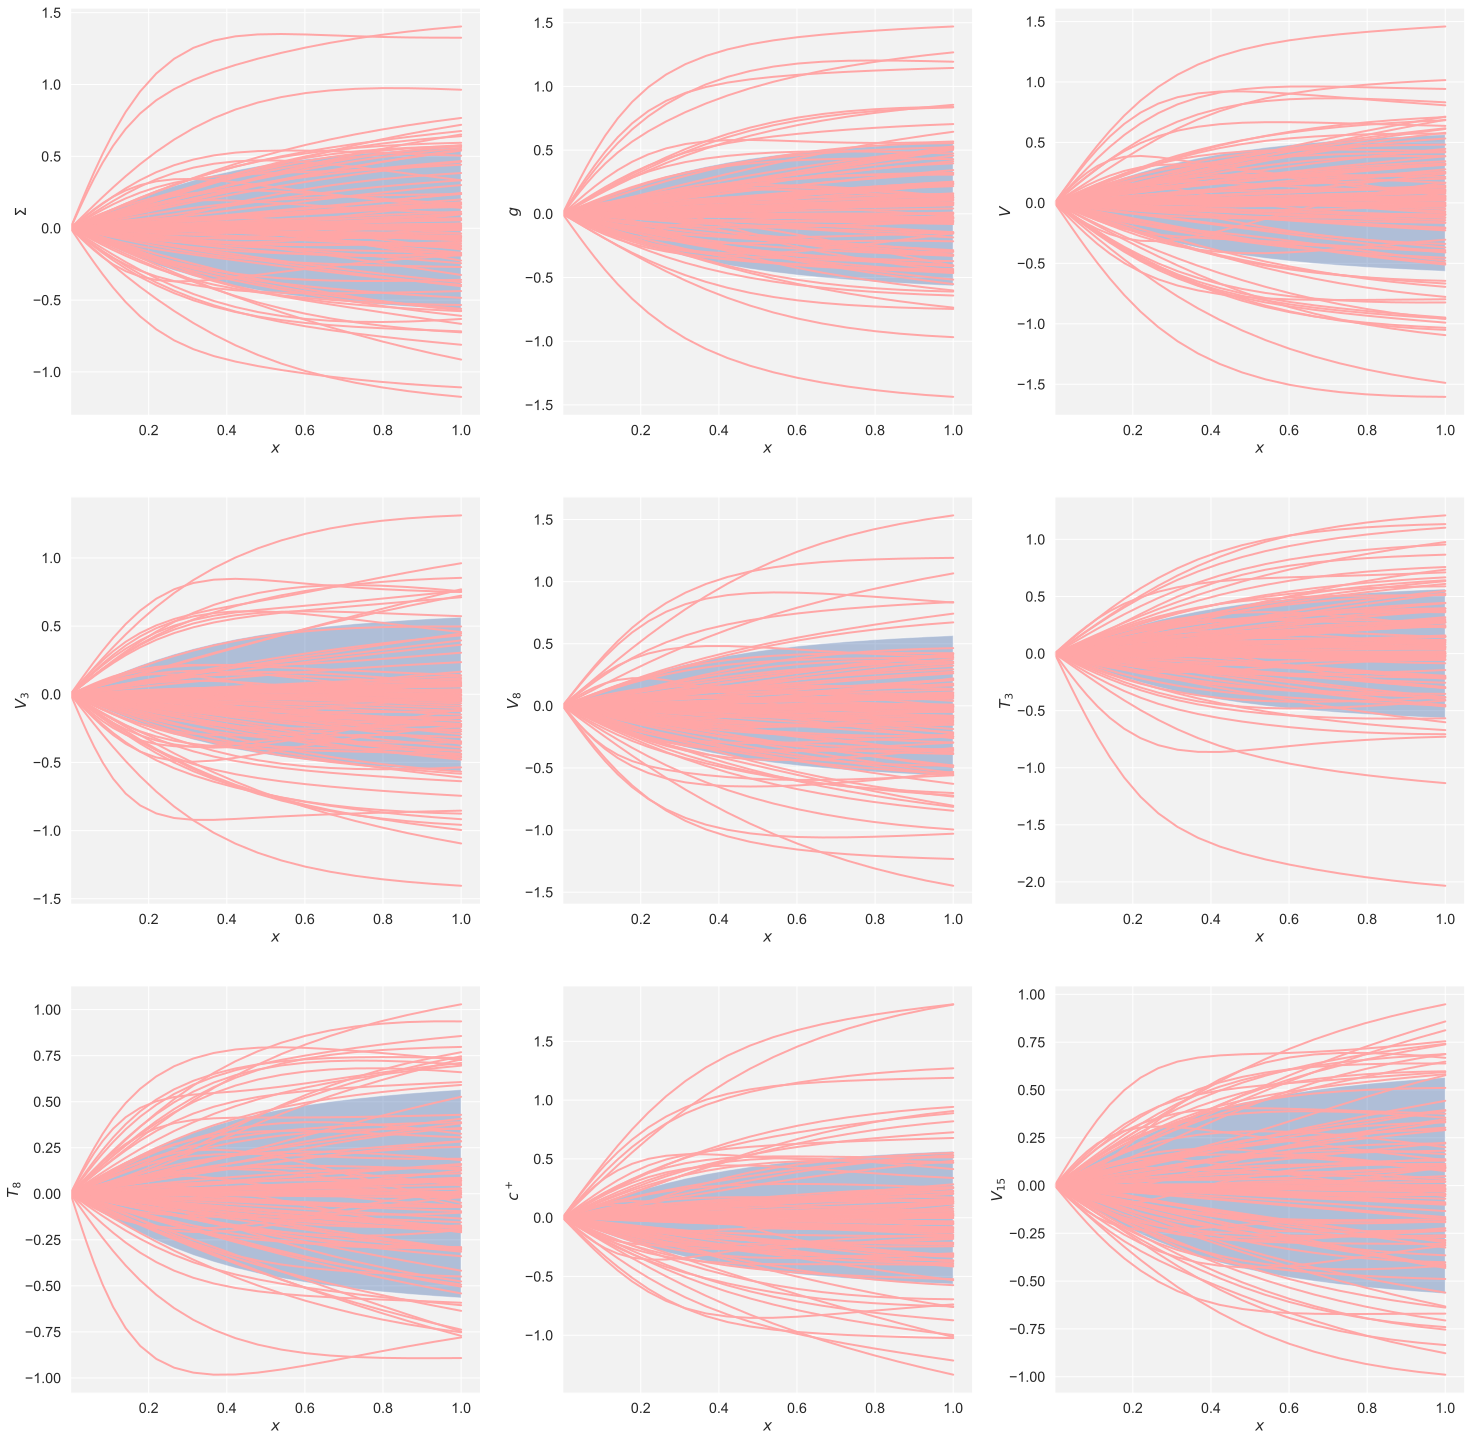

In [13]:
from utils import fk_ev_map
# Plot the components of the svd
fig, axes = plt.subplots(3,3, figsize=(25, 25))


kernel = kernel_fn(XGRID[:,np.newaxis], XGRID[:,np.newaxis], 'nngp')
ntk = kernel_fn(XGRID[:,np.newaxis], XGRID[:,np.newaxis], 'ntk')
std_dev = jnp.sqrt(jnp.diag(kernel))

for idx_p, p in enumerate(prior_draws):
  for idx, ax in enumerate(axes.flat):
    ax.plot(XGRID, p[:,idx], linewidth=2, color=[1, 0.65, 0.65])
    #ax.legend()
    ax.set_ylabel(fk_ev_map[idx], fontsize=15)
    #ax.set_xscale('log')
    ax.set_xlabel(r'$x$', fontsize=15)
    ax.set_xlim(1.e-5)

    if idx_p == 0:
      ax.fill_between(XGRID,  std_dev, - std_dev, alpha=0.4)


In [14]:
import scipy as sp
NTK = sp.linalg.block_diag(*[ntk for _ in range(9)])

Construct matric $H$ defined as
$$
H = L(FK) \Theta_t \left[L (FK) \right]^T
$$

In [15]:
try:
    assert(np.allclose(NTK, NTK.T))
except AssertionError:
    print('The NTK is not symmetric')

A = L @ FK
H = A @ NTK @ A.T

try:
    assert(np.allclose(H, H.T))
except AssertionError:
    print(f'Matrix H is not symmetric')
else:
  eigvals, eigvecs = np.linalg.eigh(H)
  eigvals = eigvals[::-1]
  eigvecs = eigvecs[:,::-1]

In [96]:
eigvals_reg = np.zeros_like(eigvals)
for i in range(eigvals.size):
  eigvals_reg[i] = round_float32(eigvals[i], eigvals[0], tol_magnitude=1.e-12)

In [97]:
for idx, val in enumerate(eigvals_reg):
  print(f'{idx} : {val}')

0 : 244704.25795908624
1 : 138128.0460927692
2 : 67635.85817523528
3 : 38506.23650346657
4 : 20350.03028320658
5 : 5703.235551782097
6 : 3236.7502836100466
7 : 816.6467427949262
8 : 157.3023487624235
9 : 122.61156013386811
10 : 40.582732827012215
11 : 20.956998977777054
12 : 15.264889556107455
13 : 10.33020071155692
14 : 3.0307454551321666
15 : 2.131208888585884
16 : 0.3464328724616174
17 : 0.10604495792354914
18 : 0.09319981706615862
19 : 0.02872296988995343
20 : 0.018728462489023885
21 : 0.0026936042132593035
22 : 0.001519506075695998
23 : 0.0013128667602274827
24 : 0.0010733250723942453
25 : 0.0007413401302796226
26 : 0.0006139273357463902
27 : 0.00035623430271697435
28 : 0.0002053089213374209
29 : 0.00014022684320774267
30 : 0.00011528309474899461
31 : 7.511911302695056e-05
32 : 6.686682738272413e-05
33 : 5.549725127535048e-05
34 : 4.379034606471052e-05
35 : 3.268720140276929e-05
36 : 2.4291179703311786e-05
37 : 1.9908801653673636e-05
38 : 1.7686018082091844e-05
39 : 4.636171638403

### Compute and regularise matrix $ M = (FK)^{T} C_{Y}^{-1} (FK)$.

In [18]:
M = FK.T @ Cinv.to_numpy() @ FK

In [19]:
M_pinv = np.linalg.pinv(M, hermitian=True, rcond=1.e-8)

In [20]:
# Regularization term from GD
M_gd = M.T @ NTK @ M 

In [21]:
eta_id = 0.001
eta_gd = 0.0
Mr = M + eta_id * np.identity(M.shape[0]) + eta_gd * M_gd
M_inv = np.linalg.inv(Mr)

In [22]:
# Construct dataframe for predictions
Y = pd.DataFrame(np.zeros(Cinv.shape[0]), index=Cinv.index)
for exp_name, data in central_data_dict.items():
  if data.size == Y.loc[(slice(None), [exp_name], slice(None)), :].size:
    Y.loc[(slice(None), [exp_name], slice(None)), :] = data
  else:
    raise ValueError

In [98]:
eps_0 = [Y.to_numpy()[:,0] - FK @ p.flatten() for p in prior_draws]
Ly = (L @ Y).to_numpy()[:,0]
Af0 = [A @ p.flatten() for p in prior_draws]
L_eps0 = [L @ eps_0_k for eps_0_k in eps_0]
FK_plus = np.linalg.pinv(FK)

L_eps0_tilde = [[np.dot(L_eps0_i, eigvecs[:,k]) for k in range(eigvecs.shape[1])] for L_eps0_i in L_eps0]
#Ly_tilde = [np.dot(Ly, eigvecs[:,k]) for k in range(eigvecs.shape[1])]

L_esp0 is not reconstructed correctly
Ly is not reconstructed correctly


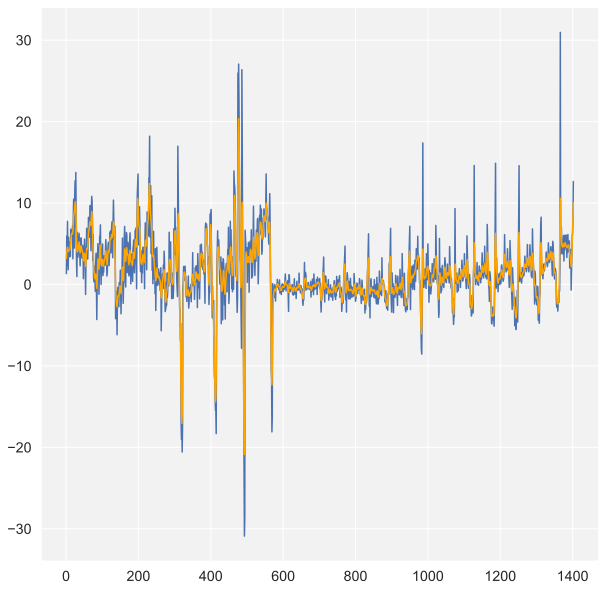

In [ ]:
aux_1 = np.zeros_like(L_eps0)
aux_2 = np.zeros_like(Ly)

for k in range(eigvals.size):
  aux_1 += L_eps0_tilde[k] * smoothed_vectors[:,k]
  aux_2 += Ly_tilde[k] * smoothed_vectors[:,k]

try:
  assert(np.allclose(aux_1, L_eps0))
except AssertionError:
  print('L_esp0 is not reconstructed correctly')

try:
  assert(np.allclose(aux_2, Ly))
except AssertionError:
  print('Ly is not reconstructed correctly')


# Plot the components of the svd
fig, axes = plt.subplots(figsize=(10, 10))
axes.plot(np.arange(1,aux_1.size+1), L_eps0, )
axes.plot(np.arange(1,aux_1.size+1), aux_1, color='orange')

In [ ]:
# Plot heatmap
hm = plt.matshow(FK_plus, cmap='viridis', norm='log')
plt.colorbar()  # Add a colorbar
plt.title("Matrix Heatmap")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

In [71]:
pdf_directions = []
for i in range(eigvals.size):
  aux = FK_plus @ eigvecs[:,i]
  pdf_directions.append(aux)

pdf_directions = np.array(pdf_directions)

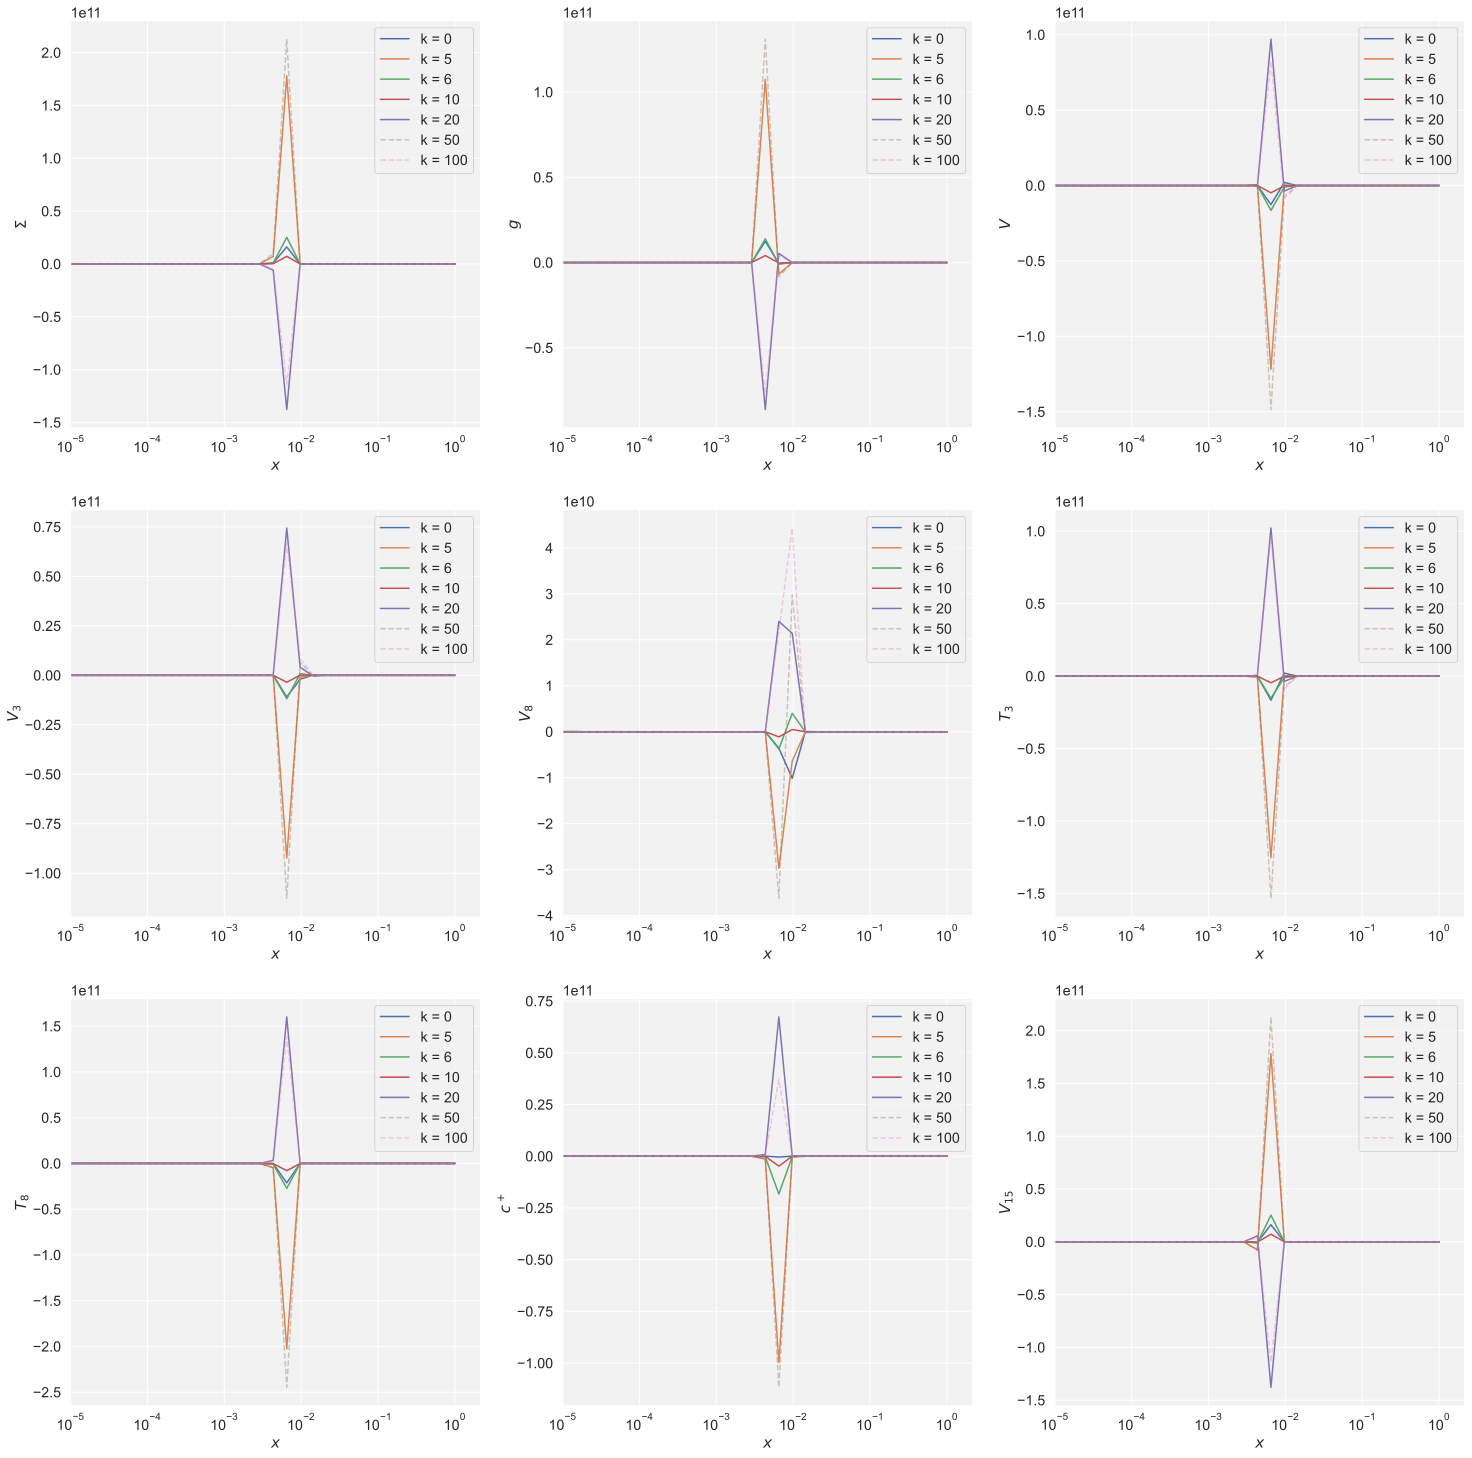

In [74]:
from utils import fk_ev_map
# Plot the components of the svd
fig, axes = plt.subplots(3,3, figsize=(25, 25))

for k in [0, 5, 6, 10, 20, 50, 100]:
  for idx, ax in enumerate(axes.flat):
    vec = pdf_directions[k]
    vec = vec.reshape((50,9))
    linestyle = 'dashed' if k > 21 else '-'
    alpha = 0.4 if k > 40 else 1.
    ax.plot(XGRID, vec[:,idx], label=f'k = {k}', linestyle=linestyle, alpha=alpha)
    ax.legend()
    if k == 0:
      ax.set_ylabel(fk_ev_map[idx], fontsize=15)
      ax.set_xscale('log')
      ax.set_xlabel(r'$x$', fontsize=15)
      ax.set_xlim(1.e-5)
      #ax.set_ylim([-0.2,0.2])

In [ ]:
from utils import PID_map, flavour_map

pdf = API.pdf(pdf="240203-02-ak-ht-tcm-disonly")
pdf_loaded = pdf.load()
pdf_central = pdf_loaded.central_member

pdf_outs = []
for x in XGRID:
  aux = pdf_central.xfxQ2(x, 1.65**2)
  pdf_outs.append([ aux[PID_map[i['fl']]] for i in flavour_map])

pdf_outs = np.array(pdf_outs)

LHAPDF 6.5.4 loading all 501 PDFs in set 240203-02-ak-ht-tcm-disonly
240203-02-ak-ht-tcm-disonly, version 1; 501 PDF members


In [ ]:
X = tf.convert_to_tensor(XGRID)
X = tf.reshape(X, shape=(-1,1))

nnpdf_w_preds = generate_sequential_model(outputs=9, nlayers=2, units=[28, 20],seed=seed, name='NNPDF', kernel_initializer=tf.keras.initializers.GlorotNormal, predictions=True, fk_table_dict=fk_table_dict, dtype='float64')
predictions = nnpdf_w_preds(X)

# Define optimizer
learning_rate_gd = 1.e-7
learning_rate_adam = 0.001
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_gd)
custom_optimizer = False
predictions_in_time = []

pdf_from_model = tf.keras.models.Sequential(nnpdf_w_preds.layers[:-1])
predictions_in_time.append(pdf_from_model(X))

try:
  f0_1 = predictions_in_time[0]
  assert(np.allclose(f0_1, f0))
except AssertionError:
  raise ValueError('Problem encountered')

for step in range(1000):  # Number of epochs/iterations
  with tf.GradientTape(persistent=False) as tape:
      # Forward pass: Compute predictions
      predictions = nnpdf_w_preds(X)
      #preds = [pred for pred in predictions.values()]

      loss = 0
      for exp, pred in predictions.items():
        Cinv_exp = tf.convert_to_tensor(Cinv.xs(level="dataset", key=exp).T.xs(level="dataset", key=exp).to_numpy(), name=f'Cinv_{exp}', dtype='float32')
        R = tf.convert_to_tensor(pred - np.array(central_data_dict[exp]), name=f'residue_{exp}', dtype='float32')
        Cinv_R = tf.linalg.matvec(Cinv_exp, R)
        loss += 0.5 * tf.reduce_sum(tf.multiply(R, Cinv_R))

      gradients = tape.gradient(loss, nnpdf_w_preds.trainable_variables)

      if custom_optimizer:
        for grad, weight in zip(gradients, nnpdf_w_preds.weights):
          new_weights = weight.value - learning_rate_gd * grad
          weight.assign(new_weights)
      else:
        optimizer.apply_gradients(zip(gradients, nnpdf_w_preds.trainable_variables))

      if step % 100 == 0:
        print('------------------------')
        print(f"Step {step}, Loss: {loss.numpy()}")

  pdf_from_model = tf.keras.models.Sequential(nnpdf_w_preds.layers[:-1])
  predictions_in_time.append(pdf_from_model(X))

NameError: name 'f0' is not defined

In [ ]:
f_inf = M_inv @ A.T @ Ly
t = 0.0 * 0.0000005
evolution = np.zeros_like(f_inf)
for k in range(eigvals_reg.size):
   vk_L_epso = np.dot(eigvecs[:,k], L @ eps_0 )
   vec = M_inv @ A.T @ eigvecs[:,k]
   evolution += np.exp(- eigvals_reg[k] * t) * vk_L_epso * vec

ft_proj = f_inf - evolution
ft_proj = ft_proj.reshape((50,9))
f_inf = f_inf.reshape((50,9)) 

In [ ]:
from utils import produce_R_ev_9_to_flav_8

rotmap = produce_R_ev_9_to_flav_8()
pdf_rotated = pdf_outs @ rotmap

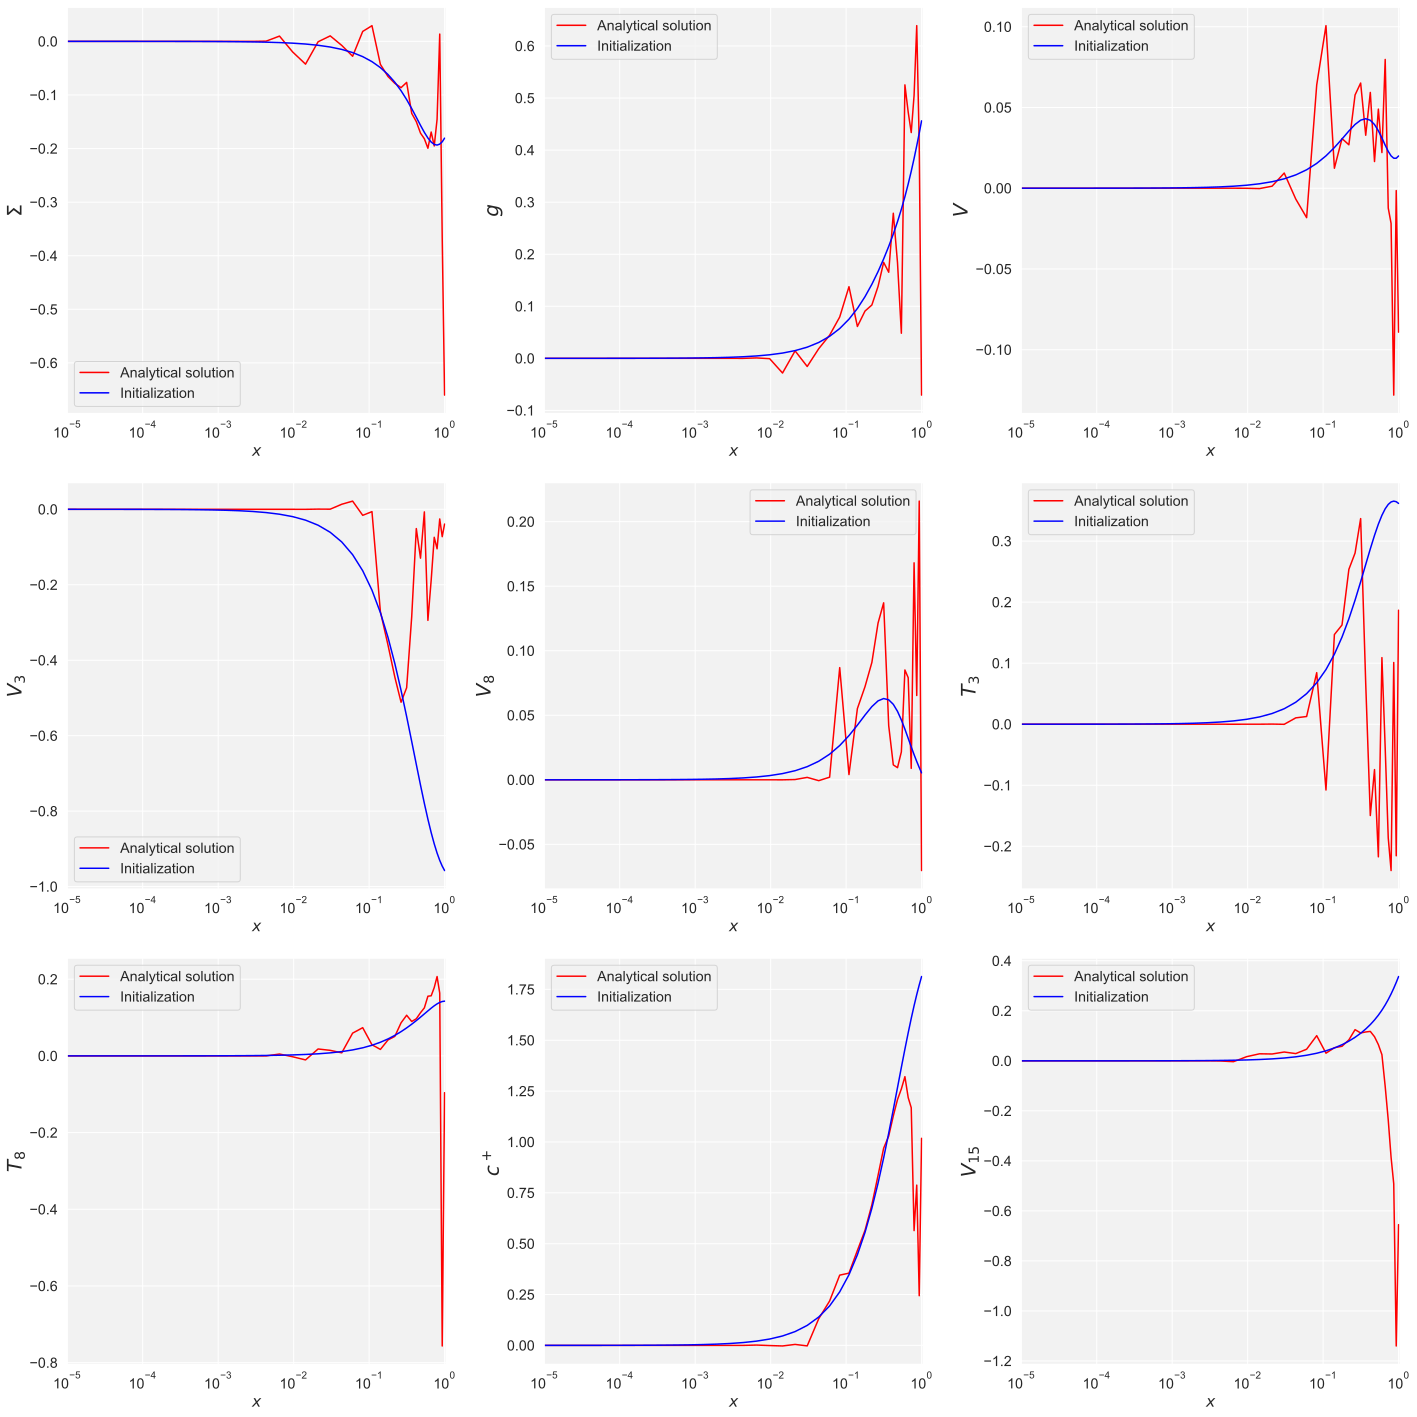

In [57]:
from matplotlib.animation import FuncAnimation
import matplotlib
from utils import fk_ev_map
matplotlib.rcParams['animation.embed_limit'] = 2**128

fig, axes = plt.subplots(3, 3, figsize=(20, 20))  # Adjust figsize for desired plot size

lines = []

for i, ax in enumerate(axes.flat):

    line, = ax.plot(XGRID, ft_proj.T[i,:], color='red', label='Analytical solution')
    #ax.plot(XGRID, predictions_in_time[5][:,i], color='green', label='Trained NN')
    ax.plot(XGRID, prior_draws[0][:,i], color='blue', label='Initialization')
    #ax.plot(XGRID, f_inf[:,i], color='orange', label='Infinity')
    lines.append(line)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(fk_ev_map[i], fontsize=20)
    ax.set_xscale('log')
    ax.set_xlim(1e-5,1.05)
    ax.legend()

plt.tight_layout()
